In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# ====== 1. Upload CSV ======
df = pd.read_csv("Global_Development_Indicators_2000_2020.csv")

# Remove irrelevant columns
drop_cols = ['country_code', 'currency_unit', 'region', 'gdp_per_capita', 'calculated_gdp_per_capita']
df_clean = df.drop(columns=drop_cols, errors='ignore')
df_clean = df_clean.dropna(subset=['gdp_usd'])



# ====== 2. Initial filter: countries with at least 15 records ======
counts = df_clean.groupby("country_name")["gdp_usd"].count()
valid_countries = counts[counts >= 15].index
df_clean = df_clean[df_clean["country_name"].isin(valid_countries)]



# ====== 3. Save columns for analysis ======
country_year = df_clean[['country_name', 'year']].copy()
categorical = ['income_group']
X = df_clean.drop(columns=['gdp_usd', 'country_name', 'year'])
y = df_clean['gdp_usd']
X_encoded = pd.get_dummies(X, columns=categorical)



# ====== 4. Initial Training ======
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)
cy_test = country_year.loc[y_test.index]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# ====== 5. Calculate error by country ======
errors_df = cy_test.copy()
errors_df['y_true'] = y_test
errors_df['y_pred'] = y_pred
errors_df['abs_error'] = np.abs(y_test - y_pred)
errors_df['pct_error'] = 100 * errors_df['abs_error'] / y_test


# Top 10 countries with the highest mean error
top_error_countries = (
    errors_df.groupby("country_name")['pct_error']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)

print("\n🚫 Eliminating countries with the highest percentage error:")
print(list(top_error_countries))

# ====== 6. Filter dataset by removing those countries ======
df_clean = df_clean[~df_clean['country_name'].isin(top_error_countries)]


# ====== 7. Prepare clean data ======
country_year = df_clean[['country_name', 'year']].copy()
X = df_clean.drop(columns=['gdp_usd', 'country_name', 'year'])
y = df_clean['gdp_usd']
X_encoded = pd.get_dummies(X, columns=categorical)

# ====== 8. Retrain model ======
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)
cy_test = country_year.loc[y_test.index]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# ====== 9. Metrics after filtering ======
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\n📊 RMSE (final): {rmse:,.2f}")
print(f"📈 R² Score (final): {r2:.4f}")
print(f"📉 MAPE (final): {mape:.2f}%")


# ====== 10. Chart: Predicted vs Actual ======
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real GDP (USD)")
plt.ylabel("Predicted GDP (USD)")
plt.title("GDP: Actual vs Predicted (without top 10 countries with the biggest error)")
plt.tight_layout()
plt.show()


🚫 Eliminating countries with the highest percentage error:
['Liechtenstein', 'Tuvalu', 'Seychelles', 'Kiribati', 'Palau', 'Marshall Islands', 'St. Vincent and the Grenadines', 'Vanuatu', 'Solomon Islands', 'Dominica']

📊 RMSE (final): 805,347,820,531.42
📈 R² Score (final): 0.9887
📉 MAPE (final): 13.44%


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# ====== 1. Upload CSV ======
df = pd.read_csv("Global_Development_Indicators_2000_2020.csv")

# Remove irrelevant columns
drop_cols = ['country_code', 'currency_unit', 'region', 'gdp_per_capita', 'calculated_gdp_per_capita']
df_clean = df.drop(columns=drop_cols, errors='ignore')
df_clean = df_clean.dropna(subset=['gdp_usd'])


# ====== 2. Initial filter: countries with at least 15 records ======
counts = df_clean.groupby("country_name")["gdp_usd"].count()
valid_countries = counts[counts >= 15].index
df_clean = df_clean[df_clean["country_name"].isin(valid_countries)]


# ====== 3. Save columns ======
country_year = df_clean[['country_name', 'year']].copy()


# ====== 4. Prepare X and y (log-transform) ======
categorical = ['income_group']
X = df_clean.drop(columns=['gdp_usd', 'country_name', 'year'])
y_log = np.log1p(df_clean['gdp_usd'])  # log(1 + GDP)
X_encoded = pd.get_dummies(X, columns=categorical)

# ====== 5. Split ======
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_encoded, y_log, test_size=0.2, random_state=42
)
cy_test = country_year.loc[y_test_log.index]


# ====== 6. Model ======
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train_log)


# Predictions on log scale
y_pred_log = model.predict(X_test)

# Revert to original scale
y_test = np.expm1(y_test_log)
y_pred = np.expm1(y_pred_log)


# ====== 7. Metrics ======
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\n📊 RMSE: {rmse:,.2f}")
print(f"📈 R² Score: {r2:.4f}")
print(f"📉 MAPE: {mape:.2f}%")


# ====== 8. Pred vs Actual Chart ======
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real GDP (USD)")
plt.ylabel("Predicted GDP (USD)")
plt.title("GDP: Actual vs Predicted (with log-transform)")
plt.tight_layout()
plt.show()


# ====== 9. Errors by country ======
errors_df = cy_test.copy()
errors_df['y_true'] = y_test
errors_df['y_pred'] = y_pred
errors_df['abs_error'] = np.abs(y_test - y_pred)
errors_df['pct_error'] = 100 * errors_df['abs_error'] / y_test

top_errors = errors_df.sort_values(by='pct_error', ascending=False).head(10)
print("\n🔍 Países con mayor error porcentual:")
print(top_errors[['country_name', 'year', 'y_true', 'y_pred', 'abs_error', 'pct_error']])


# Top 10 Error Chart
plt.figure(figsize=(10, 6))
sns.barplot(data=top_errors, x='pct_error', y='country_name', palette='rocket', hue="country_name")
plt.title("Top 10 countries with the highest percentage error in GDP")
plt.xlabel("Percent error (%)")
plt.ylabel("country")
plt.tight_layout()
plt.show()


📊 RMSE: 824,959,493,556.48
📈 R² Score: 0.9887
📉 MAPE: 9.47%



🔍 Países con mayor error porcentual:
                    country_name  year        y_true        y_pred  \
1721                      Tuvalu  2020  4.885555e+07  3.296849e+08   
1259                    Kiribati  2020  1.975088e+08  1.106050e+09   
1532                       Palau  2020  2.577000e+08  9.627989e+08   
1342            Marshall Islands  2019  2.394622e+08  6.871334e+08   
5408                  Seychelles  2020  1.059886e+09  2.761401e+09   
5471                    Tanzania  2020  6.240971e+10  1.303624e+11   
61                    Arab World  2019  2.776469e+12  5.381046e+12   
586   Middle East & North Africa  2019  3.406150e+12  6.477461e+12   
1344                     Myanmar  2000  6.849322e+09  1.293021e+10   
4598                     Burundi  2020  2.841786e+09  5.096774e+09   

         abs_error   pct_error  
1721  2.808294e+08  574.815712  
1259  9.085413e+08  460.000490  
1532  7.050989e+08  273.612287  
1342  4.476712e+08  186.948577  
5408  1.701514e+09  160.53


📊 RMSE: 824,959,493,556.48
📈 R² Score: 0.9887
📉 MAPE: 9.47%

🚨 Outlier detectado:
     country_name  year        y_true        y_pred     abs_error   pct_error
1721       Tuvalu  2020  4.885555e+07  3.296849e+08  2.808294e+08  574.815712


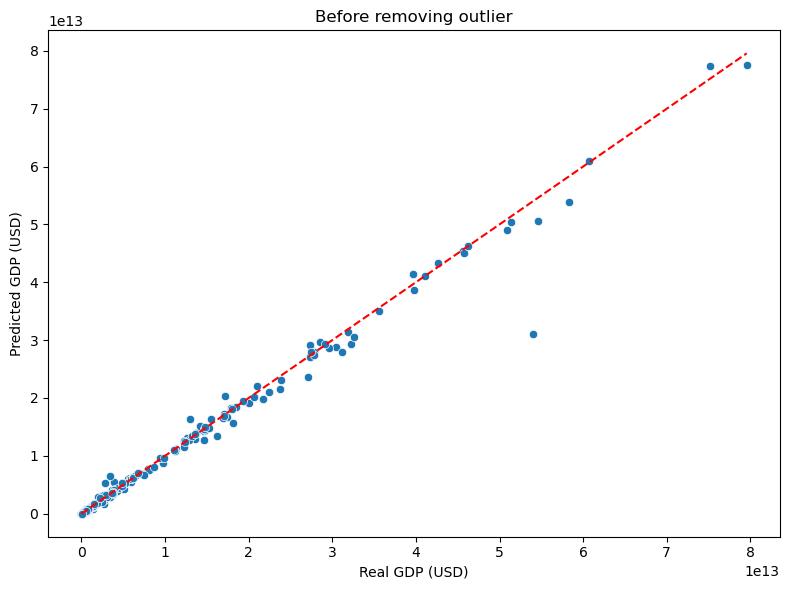


📊 RMSE after: 800,645,110,480.22
📈 R² after: 0.9895
📉 MAPE after: 9.79%


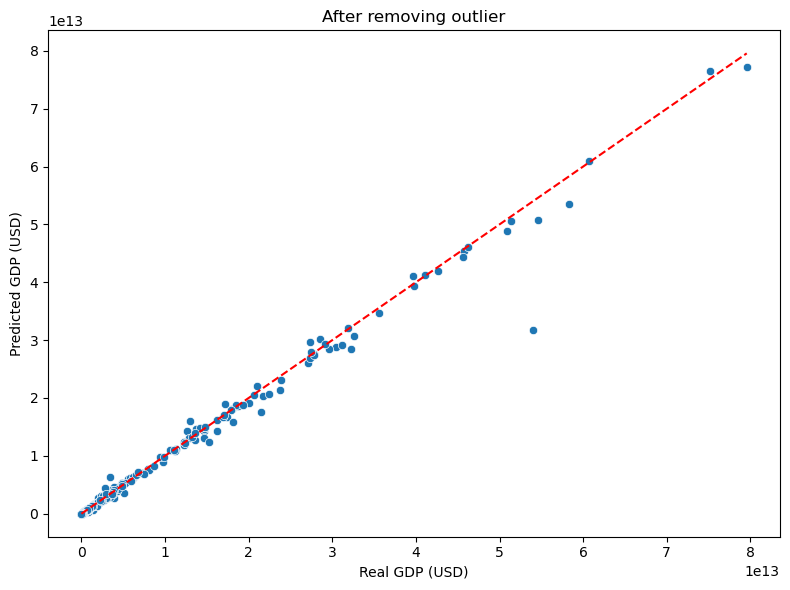

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# ====== 1. Upload CSV ======
df = pd.read_csv("Global_Development_Indicators_2000_2020.csv")

# Remove irrelevant columns
drop_cols = ['country_code', 'currency_unit', 'region', 'gdp_per_capita', 'calculated_gdp_per_capita']
df_clean = df.drop(columns=drop_cols, errors='ignore')
df_clean = df_clean.dropna(subset=['gdp_usd'])

# Initial filter: countries with at least 15 records
counts = df_clean.groupby("country_name")["gdp_usd"].count()
valid_countries = counts[counts >= 15].index
df_clean = df_clean[df_clean["country_name"].isin(valid_countries)]

categorical = ['income_group']


# ====== Function to train and detect outliers ======
def train_and_detect(data, top_n_outliers=1):
    country_year = data[['country_name', 'year']].copy()
    X = data.drop(columns=['gdp_usd', 'country_name', 'year'])
    y_log = np.log1p(data['gdp_usd'])
    X_encoded = pd.get_dummies(X, columns=categorical)

    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X_encoded, y_log, test_size=0.2, random_state=42
    )
    cy_test = country_year.loc[y_test_log.index]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train_log)

    
    # Predictions
    y_pred_log = model.predict(X_test)
    y_test = np.expm1(y_test_log)
    y_pred = np.expm1(y_pred_log)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Errors
    errors_df = cy_test.copy()
    errors_df['y_true'] = y_test
    errors_df['y_pred'] = y_pred
    errors_df['abs_error'] = np.abs(y_test - y_pred)
    errors_df['pct_error'] = 100 * errors_df['abs_error'] / y_test

    # Detect outliers (top N by percentage error)
    top_outliers = errors_df.sort_values(by='pct_error', ascending=False).head(top_n_outliers)

    return model, rmse, r2, mape, top_outliers, X_train, X_test, y_train_log, y_test, y_pred, errors_df

# ====== 1st run: detect outlier ======
model, rmse, r2, mape, top_outliers, X_train, X_test, y_train_log, y_test, y_pred, errors_df = train_and_detect(df_clean, top_n_outliers=1)

print(f"\n📊 RMSE: {rmse:,.2f}")
print(f"📈 R² Score: {r2:.4f}")
print(f"📉 MAPE: {mape:.2f}%")
print("\n🚨 Outlier detectado:")
print(top_outliers)


# ====== Graph before deleting ======
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real GDP (USD)")
plt.ylabel("Predicted GDP (USD)")
plt.title("Before removing outlier")
plt.tight_layout()
plt.show()


# ====== Remove outlier from dataset ======
outlier_country = top_outliers.iloc[0]['country_name']
outlier_year = top_outliers.iloc[0]['year']

df_clean_filtered = df_clean[~((df_clean['country_name'] == outlier_country) & (df_clean['year'] == outlier_year))]


# ====== 2nd execution: after deleting ======
model, rmse, r2, mape, _, _, _, _, y_test, y_pred, _ = train_and_detect(df_clean_filtered, top_n_outliers=1)

print(f"\n📊 RMSE after: {rmse:,.2f}")
print(f"📈 R² after: {r2:.4f}")
print(f"📉 MAPE after: {mape:.2f}%")

# ====== Graph after deleting ======
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real GDP (USD)")
plt.ylabel("Predicted GDP (USD)")
plt.title("After removing outlier")
plt.tight_layout()
plt.show()


📊 Iteración 1 - RMSE: 1,044,072,878,234.91, R²: 0.9826, MAPE: 8.75%
🚨 Eliminando 84 outliers con error > 20%

📊 Iteración 2 - RMSE: 2,011,728,378,052.80, R²: 0.9302, MAPE: 9.40%
🚨 Eliminando 96 outliers con error > 20%

📊 Iteración 3 - RMSE: 1,180,662,569,597.62, R²: 0.9701, MAPE: 8.50%
🚨 Eliminando 87 outliers con error > 20%

📊 Iteración 4 - RMSE: 598,304,907,676.69, R²: 0.9915, MAPE: 8.30%
🚨 Eliminando 90 outliers con error > 20%

📊 Iteración 5 - RMSE: 622,702,058,329.48, R²: 0.9916, MAPE: 7.95%
🚨 Eliminando 70 outliers con error > 20%

📊 Iteración 6 - RMSE: 444,959,992,180.21, R²: 0.9955, MAPE: 8.38%
🚨 Eliminando 69 outliers con error > 20%

📊 Iteración 7 - RMSE: 457,828,998,684.39, R²: 0.9955, MAPE: 10.49%
🚨 Eliminando 61 outliers con error > 20%

📊 Iteración 8 - RMSE: 551,530,823,552.42, R²: 0.9936, MAPE: 9.05%
🚨 Eliminando 50 outliers con error > 20%

📊 Iteración 9 - RMSE: 566,123,189,818.14, R²: 0.9940, MAPE: 7.46%
🚨 Eliminando 56 outliers con error > 20%

📊 Iteración 10 - RMS

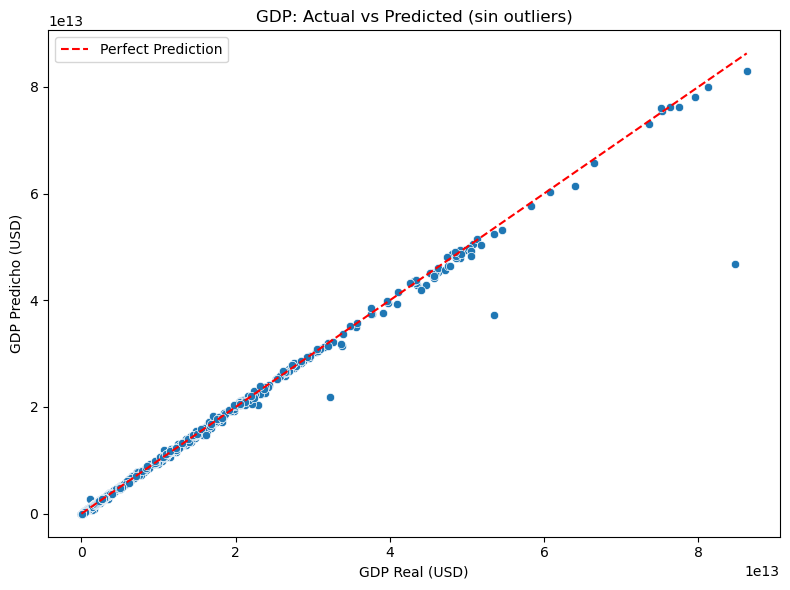

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# === 1. Carga de datos ===
df = pd.read_csv("Global_Development_Indicators_2000_2020.csv")

# === 2. Limpieza inicial ===
drop_cols = ['country_code', 'currency_unit', 'region', 'gdp_per_capita', 'calculated_gdp_per_capita']
df_clean = df.drop(columns=drop_cols, errors='ignore')
df_clean = df_clean.dropna(subset=['gdp_usd'])
country_year = df_clean[['country_name', 'year']].copy()

categorical = ['income_group']
X = df_clean.drop(columns=['gdp_usd', 'country_name', 'year'])
y = np.log1p(df_clean['gdp_usd'])  # Escala logarítmica
X_encoded = pd.get_dummies(X, columns=categorical)

# === Función para entrenar y eliminar outliers ===
def clean_outliers(X, y, cy, error_threshold=20, max_iter=10):
    iteration = 1
    while iteration <= max_iter:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        cy_test = cy.loc[y_test.index]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)
        y_true = np.expm1(y_test)

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        print(f"\n📊 Iteración {iteration} - RMSE: {rmse:,.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

        # Errores
        errors_df = cy_test.copy()
        errors_df['y_true'] = y_true
        errors_df['y_pred'] = y_pred
        errors_df['pct_error'] = 100 * np.abs(y_true - y_pred) / y_true

        # Detectar outliers
        outliers_idx = errors_df[errors_df['pct_error'] > error_threshold].index
        if len(outliers_idx) == 0:
            print("✅ No hay más outliers por encima del umbral.")
            break

        print(f"🚨 Eliminando {len(outliers_idx)} outliers con error > {error_threshold}%")
        X = X.drop(index=outliers_idx)
        y = y.drop(index=outliers_idx)
        cy = cy.drop(index=outliers_idx)

        iteration += 1

    # === Modelo final ===
    model_final = RandomForestRegressor(n_estimators=100, random_state=42)
    model_final.fit(X, y)

    y_pred_log_final = model_final.predict(X)
    y_pred_final = np.expm1(y_pred_log_final)
    y_true_final = np.expm1(y)

    # === Gráfico final ===
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true_final, y=y_pred_final)
    plt.plot([y_true_final.min(), y_true_final.max()],
             [y_true_final.min(), y_true_final.max()],
             'r--', label="Perfect Prediction")
    plt.xlabel("GDP Real (USD)")
    plt.ylabel("GDP Predicho (USD)")
    plt.title("GDP: Actual vs Predicted (sin outliers)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return X, y, cy

# === Ejecutar limpieza rápida de outliers ===
X_clean, y_clean, cy_clean = clean_outliers(X_encoded, y, country_year, error_threshold=20, max_iter=10)